In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
TOTAL_ROWS = 10000

COLUMNS = [
    'electrode force',
    'electrode contact surface diameter',
    'squeeze time',
    'weld time',
    'hold time',
    'weld current',
    'leak rate',
    'explosive force',
    'leaking',
    'explosion'
]

INPUT_COLUMNS = [
    'electrode force',
    'electrode contact surface diameter',
    'squeeze time',
    'weld time',
    'hold time',
    'weld current'
]

OUTPUT_COLUMNS = [
    'leak rate',
    'explosive force',
    'leaking',
    'explosion'
]

CATEGORICAL_LABELS = ['leaking', 'explosion']

In [ ]:
def generate_coefficients(input_length, output_length):
    mean = 0
    stddev = 5.0
    rows = input_length
    columns = output_length
    return np.random.normal(mean, stddev, size=(rows, columns))

def generate_row(coefficients):
    rows, columns = coefficients.shape
    input_row = np.random.rand(columns)
    output = np.matmul(coefficients, input_row)
    output = output.tolist()
    assert len(output) >= 4
    output[-2] = "leaking" if output[-4] > 0 else "not leaking"
    output[-1] = "explosion" if output[-3] > 0 else "no explosion"
    output = input_row.tolist() + output
    return output

def generate_sets(myset, output_columns, categorical_labels):
    myset_labels = myset[output_columns].copy()
    myset = myset.drop(output_columns, axis=1)
    myset_categorical = myset_labels[categorical_labels]
    categorical_encoder = OneHotEncoder()
    myset_categorical = categorical_encoder.fit_transform(myset_categorical)
    myset_categorical = myset_categorical.toarray()
    return myset, myset_labels, myset_categorical, categorical_encoder

In [ ]:
my_dataframe = pd.DataFrame(columns=COLUMNS)
coefficients = generate_coefficients(len(INPUT_COLUMNS), len(OUTPUT_COLUMNS))
for i in range(TOTAL_ROWS):
    my_dataframe.loc[len(my_dataframe)] = generate_row(coefficients)
print(my_dataframe.head())

   electrode force  electrode contact surface diameter  squeeze time  \
0         0.609336                            0.952825      0.263042   
1         0.580007                            0.842750      0.150881   
2         0.720830                            0.320104      0.641815   
3         0.743685                            0.321591      0.845789   
4         0.732430                            0.587996      0.562799   

   weld time  hold time  weld current  leak rate  explosive force  \
0   0.050026 -12.753733     -0.496401  -3.998930         1.111612   
1   0.394470 -10.438163      0.761746  -5.040975         2.036024   
2   0.319790 -13.492008     -4.977646  -4.275528         1.084537   
3   0.987438 -14.259645     -6.762394  -6.714627         3.898951   
4   0.614062 -13.744697     -3.600671  -5.858485         2.613446   

       leaking  explosion  
0  not leaking  explosion  
1  not leaking  explosion  
2  not leaking  explosion  
3  not leaking  explosion  
4  not leaki

In [ ]:
X_train, X_test = train_test_split(my_dataframe, test_size=0.2, random_state=42)
X_train, X_validation = train_test_split(X_train)

X_train_labels = X_train[OUTPUT_COLUMNS].copy()
X_train = X_train.drop(OUTPUT_COLUMNS, axis=1)
X_train_categorical = X_train_labels[CATEGORICAL_LABELS]
X_train_labels = X_train_labels.drop(CATEGORICAL_LABELS, axis=1)
train_categorical_encoder = OneHotEncoder()
X_train_categorical = train_categorical_encoder.fit_transform(X_train_categorical)
X_train_categorical = X_train_categorical.toarray()

X_test_labels = X_test[OUTPUT_COLUMNS].copy()
X_test = X_test.drop(OUTPUT_COLUMNS, axis=1)
X_test_categorical = X_test_labels[CATEGORICAL_LABELS]
X_test_labels = X_test_labels.drop(CATEGORICAL_LABELS, axis=1)
test_categorical_encoder = OneHotEncoder()
X_test_categorical = test_categorical_encoder.fit_transform(X_test_categorical)
X_test_categorical = X_test_categorical.toarray()

X_validation_labels = X_validation[OUTPUT_COLUMNS].copy()
X_validation = X_validation.drop(OUTPUT_COLUMNS, axis=1)
X_validation_categorical = X_validation_labels[CATEGORICAL_LABELS]
X_validation_labels = X_validation_labels.drop(CATEGORICAL_LABELS, axis=1)
validation_categorical_encoder = OneHotEncoder()
X_validation_categorical = validation_categorical_encoder.fit_transform(X_validation_categorical)
X_validation_categorical = X_validation_categorical.toarray()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

print(X_train_categorical[:10])
print(train_categorical_encoder.categories_)

[[0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]]
[array(['leaking', 'not leaking'], dtype=object), array(['explosion', 'no explosion'], dtype=object)]


In [ ]:
y_train_regression = X_train_labels
y_train_classification = X_train_categorical
y_test_regression = X_test_labels
y_test_classification = X_test_categorical
y_validation_regression = X_validation_labels
y_validation_classification = X_validation_categorical

y_train = y_train_regression
y_test = y_test_regression
y_validation = y_validation_regression

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
INPUT_WIDTH = len(INPUT_COLUMNS)
OUTPUT_WIDTH = len(OUTPUT_COLUMNS)
numerical_output_width = y_train.shape[1]
categorical_output_width = y_train_classification.shape[1]

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(INPUT_WIDTH,)))
model.add(keras.layers.Dense(INPUT_WIDTH * 10, activation="relu"))
model.add(keras.layers.Dense(INPUT_WIDTH * 5, activation="relu"))
model.add(keras.layers.Dense(INPUT_WIDTH * 1, activation="relu"))
#model.add(keras.layers.Dense(numerical_output_width, activation="softmax"))
model.add(keras.layers.Dense(numerical_output_width))
#model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
model.compile(loss="mse", optimizer="adam", metrics=["mse"])
history = model.fit(X_train,
    y_train,
    epochs=30,
    validation_data=(X_validation, y_validation))
mse_test = model.evaluate(X_test, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.7162 - mse: 8.7162 - val_loss: 0.4412 - val_mse: 0.4412
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3412 - mse: 0.3412 - val_loss: 0.1639 - val_mse: 0.1639
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1271 - mse: 0.1271 - val_loss: 0.0445 - val_mse: 0.0445
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0333 - mse: 0.0333 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 9/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

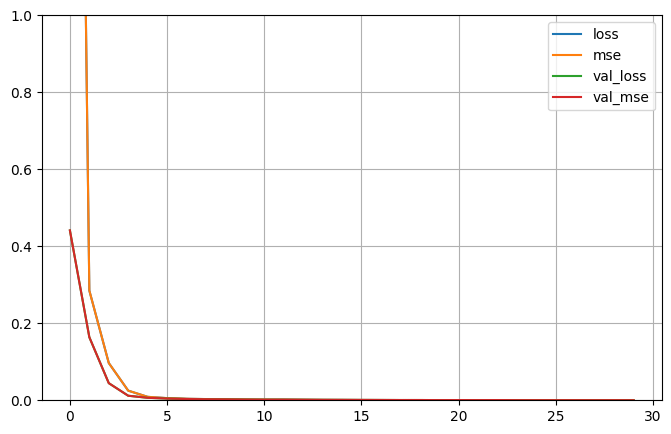

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
y_prediction = model.predict(X_test)
print(y_prediction[:10])

model_filename = "my_model.h5"
print("Saving " + model_filename)
#model.save(model_filename)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[-5.240033    3.2094018 ]
 [-5.037623    3.182618  ]
 [-5.0091963  -0.32120112]
 [-5.649169    4.23313   ]
 [-1.568627    1.8239771 ]
 [-6.1607513   1.5178729 ]
 [-2.208122    2.4504426 ]
 [-1.6856936   2.819743  ]
 [-7.5525126   3.8042152 ]
 [-1.8172711   0.5070565 ]]
Saving my_model.h5


In [ ]:
def mean_squared_error(y_true, y_predicted):
    cost = np.sum((y_true - y_predicted) ** 2) / len(y_true)
    return cost

def gradient_descent(
    x,
    y,
    model,
    iterations=1000,
    learning_rate=0.0001,
    stopping_threshold=1E-6):
    # Initialize weight, bias, learning rate, iterations
    current_weight = 0.1
    current_bias = 0.01
    n = float(len(x))
    current_x = x

    costs = []
    weights = []
    previous_cost = None

    # Estimate optimal parameters
    for i in range(iterations):
        current_x = current_weight * x + current_bias
        #TODO: Scaling
        y_predicted = model.predict(current_x)
        current_cost = mean_squared_error(y, y_predicted)
        if previous_cost and abs(previous_cost - current_cost) <= stopping_threshold:
            break
        previous_cost = current_cost
        costs.append(current_cost)
        weights.append(current_weight)
        # Calculate the gradients
        weight_derivative = -(2 / n) * sum(x * (y - y_predicted))
        bias_derivative = -(2 / n) * sum(y - y_predicted)
        #Update weights and bias
        current_weight = current_weight - (learning_rate * weight_derivative)
        current_bias = current_bias - (learning_rate * bias_derivative)
        if not i % 100:
            print(f"Iteration {i + 1}: Cost {current_cost}, Weight \
                {current_weight}, Bias {current_bias}")
    #Visualize weights and costs per iteration
    plt.figure(figsize=(8, 6))
    plt.plot(weights, costs)
    plt.scatter(weights, costs, marker='0', color='red')
    plt.title("Cost vs. Weights")
    plt.ylabel("Cost")
    plt.xlabel("Weight")
    plt.show()

    return current_x

In [ ]:
#TODO: Fix function call
#result = gradient_descent(X_test[0], np.zeros_like(y_test.to_numpy()[0]), model)
#print(result)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None